# Implementing Neural Networks with Backpropagation and Gradient Descent Lab
## Overview
You are a newly hired data scientist at HealthTech Innovations, a healthcare analytics company that works with hospitals to improve patient care through data-driven solutions. Your team has been tasked with developing a predictive model to estimate patient length of stay (LOS) at hospitals. This information is critical for resource allocation, staff scheduling, and financial planning.

Your supervisor has asked you to build a neural network that can predict the length of stay (in days) based on various patient attributes such as age, diagnosis codes, admission type, insurance type, and several health indicators. The goal is to provide hospital administrators with accurate predictions to optimize resource allocation.

This lab will guide you through the process of implementing a neural network using TensorFlow and Keras, focusing specifically on understanding the backpropagation and gradient descent algorithms that power neural network training. You'll follow a similar process to what was demonstrated in the lesson, but with a different dataset and problem context.
## Process
1. Prepare the data
2. Design a neural network architecture
3. Configure the optimization process
4. Train the models
5. Visualize the learning process
6. Evaluate performance

## Tools and Resources
To complete this lab, you will need:

- Python 3.6+
- The following libraries:
    - TensorFlow 2.x
    - Keras (included with TensorFlow)
    - NumPy
    - Pandas
    - Matplotlib
    - Scikit-learn
- Provided Starter Notebook
- Provided Dataset File: patient_los.csv

## Step 0: Libraries and Data Loading
Start by importing all the necessary libraries, setting random seeds for reproducibility, and loading in the provided data.

In [25]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
import random
from sklearn.metrics import mean_absolute_error, mean_squared_error


# Set seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

# Load the dataset
data = pd.read_csv('patient los data.csv')

## Step 1: Explore the Patient Length-of-Stay Dataset
Begin by understanding the structure and size of your data. Use visuals to help understand basic relationships. The dataset contains information about patients, including demographics, admission details, and health indicators.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 14 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   age                  100000 non-null  int64  
 1   num_procedures       100000 non-null  int64  
 2   num_medications      100000 non-null  int64  
 3   comorbidity_score    100000 non-null  int64  
 4   systolic_bp          100000 non-null  int64  
 5   diastolic_bp         100000 non-null  int64  
 6   pulse_rate           100000 non-null  int64  
 7   respiratory_rate     100000 non-null  int64  
 8   oxygen_saturation    100000 non-null  int64  
 9   emergency_admission  100000 non-null  int64  
 10  admission_type       100000 non-null  object 
 11  insurance_type       100000 non-null  object 
 12  department           100000 non-null  object 
 13  length_of_stay       100000 non-null  float64
dtypes: float64(1), int64(10), object(3)
memory usage: 10.7+ MB
None
     

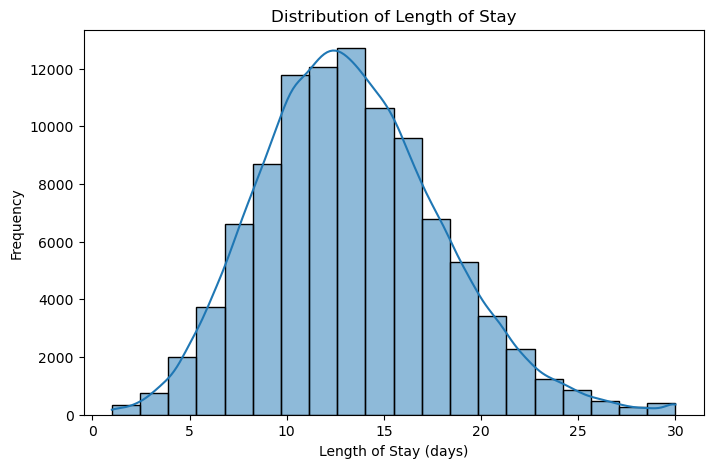

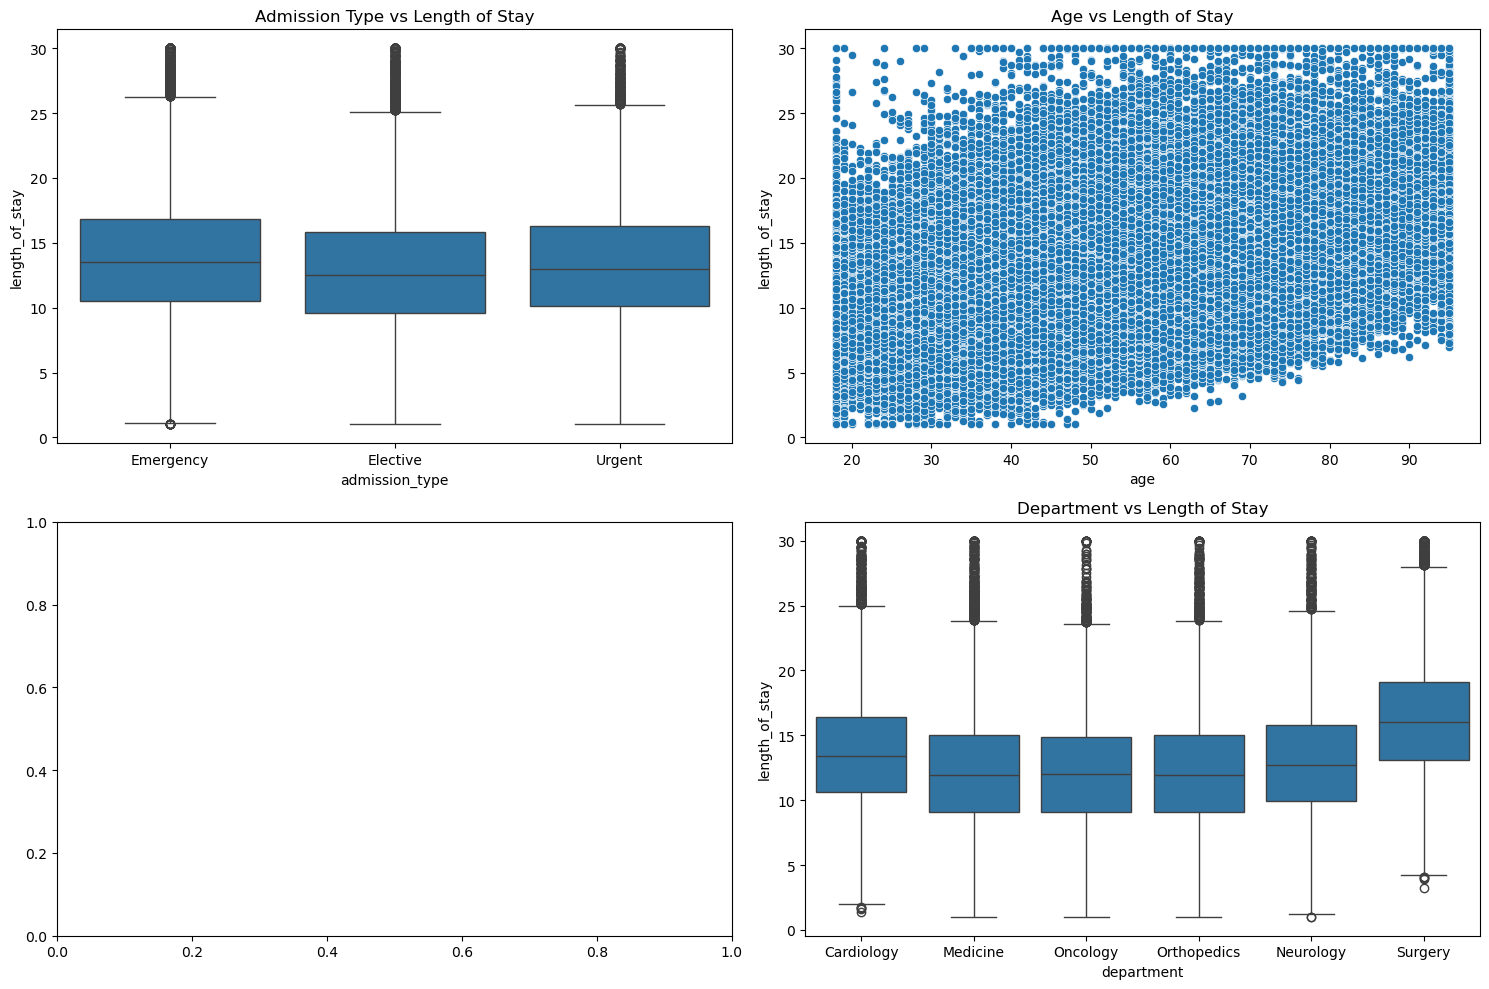


Feature correlations with length of stay:
length_of_stay         1.000000
num_procedures         0.543749
age                    0.403293
comorbidity_score      0.343153
num_medications        0.183447
emergency_admission    0.160668
systolic_bp            0.009127
pulse_rate             0.005593
diastolic_bp           0.004696
oxygen_saturation     -0.003292
respiratory_rate      -0.004677
Name: length_of_stay, dtype: float64


In [15]:
# Display basic information about the dataset
print(data.info())

# Display basic statistics
print(data.describe())

# Check for missing values
print(data.isnull().sum())

# Visualize the distribution of the target variable (length of stay)
plt.figure(figsize=(8, 5))
sns.histplot(data['length_of_stay'], bins=20, kde=True)
plt.title("Distribution of Length of Stay")
plt.xlabel("Length of Stay (days)")
plt.ylabel("Frequency")
plt.show()

# Explore relationships between features and target
plt.figure(figsize=(15, 10))

# Admission type
plt.subplot(2, 2, 1)
sns.boxplot(x='admission_type', y='length_of_stay', data=data)
plt.title("Admission Type vs Length of Stay")

# Age
plt.subplot(2, 2, 2)
sns.scatterplot(x='age', y='length_of_stay', data=data)
plt.title("Age vs Length of Stay")

# Department
plt.subplot(2, 2, 3)
None

# Number of Procedures
plt.subplot(2, 2, 4)
sns.boxplot(x='department', y='length_of_stay', data=data)
plt.title("Department vs Length of Stay")

plt.tight_layout()
plt.show()

# Calculate correlations with the target variable (numeric only)
correlations = data.corr(numeric_only=True)['length_of_stay'].sort_values(ascending=False)
print("\nFeature correlations with length of stay:")
print(correlations)

## Step 2: Prepare the Data for Training
Preprocess the data by splitting into training and testing sets and then create a column transformer pipeline that will one hot encode categorical features and standard scale numeric features.

In [16]:
# Separate features and target
X = data.drop(columns=['length_of_stay'])
y = data['length_of_stay']

# Split the data into training and testing sets (test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Get list of numerical and categorical columns
numerical_cols = ['age', 'num_procedures', 'num_medications', 'comorbidity_score',
                  'systolic_bp', 'diastolic_bp', 'pulse_rate', 'respiratory_rate',
                  'oxygen_saturation', 'emergency_admission']

categorical_cols = ['admission_type', 'insurance_type', 'department']

# Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_cols)
    ]
)

# Fit the preprocessor on training data only
X_train_processed = preprocessor.fit_transform(X_train)
# Apply the same transformation to test data
X_test_processed = preprocessor.transform(X_test)

# Get feature names after one-hot encoding (optional, for reference)
ohe_feature_names = []
if categorical_cols:
    ohe = preprocessor.named_transformers_['cat']
    ohe_categories = ohe.categories_
    ohe_feature_names = []
    for i, category in enumerate(ohe_categories):
        cat_col = categorical_cols[i]
        # Skip first category (due to drop='first')
        for cat in category[1:]:
            ohe_feature_names.append(f"{cat_col}_{cat}")

feature_names = numerical_cols + ohe_feature_names

print(f"Training set shape: {X_train_processed.shape}")
print(f"Testing set shape: {X_test_processed.shape}")
print(f"Number of features after encoding: {X_train_processed.shape[1]}")

Training set shape: (80000, 21)
Testing set shape: (20000, 21)
Number of features after encoding: 21


## Step 3: Build a Neural Network Model
Design a neural network architecture for the regression task of predicting patient length of stay.

In [17]:
# Get the number of input features
input_dim = X_train_processed.shape[1]

# Build a sequential model
model = keras.Sequential([
    # Input layer with the appropriate input shape
    keras.layers.Input(shape=(input_dim,)),
    
    # First hidden layer with 64 neurons and ReLU activation
    keras.layers.Dense(64, activation='relu'),
    
    # Second hidden layer with 32 neurons and ReLU activation
    keras.layers.Dense(32, activation='relu'),
    
    # Output layer with a single neuron (for regression)
        keras.layers.Dense(1)
])

# Display the model summary
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 64)             │         1,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,521 (13.75 KB)

 Trainable params: 3,521 (13.75 KB)

 Non-trainable params: 0 (0.00 B)

## Step 4: Configure the Training Process
Configure the model for training by selecting an optimizer, loss function, and evaluation metrics.

In [21]:
# Create and compile three different models with different optimizers
loss = 'mean_squared_error'
metric = ['mae']

# Model 1: Using SGD (Stochastic Gradient Descent)
model_sgd = keras.models.clone_model(model)
# Compile
model_sgd.compile(optimizer=keras.optimizers.SGD(learning_rate=0.01), loss=loss, metrics=metric)

# Model 2: Using RMSprop
model_rmsprop = keras.models.clone_model(model)
# Compile
model_rmsprop.compile(optimizer=keras.optimizers.RMSprop(learning_rate=0.001), loss=loss, metrics=metric)

# Model 3: Using Adam
model_adam = keras.models.clone_model(model)
# Compile
model_adam.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss=loss, metrics=metric)

# Defined number of epochs and batch size
epochs = 50
batch_size = 32

## Step 5: Train the Models and Analyze Learning
Train the three models with different optimizers and analyze their learning patterns. Make sure to use `validation_split=0.2`

Epoch 1/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 1s 275us/step - loss: 9.1063 - mae: 2.1026 - val_loss: 6.0527 - val_mae: 1.6583
Epoch 2/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 1s 255us/step - loss: 5.8902 - mae: 1.7605 - val_loss: 5.9135 - val_mae: 1.6631
Epoch 3/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 1s 257us/step - loss: 5.7699 - mae: 1.7402 - val_loss: 5.8833 - val_mae: 1.6655
Epoch 4/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 1s 257us/step - loss: 5.7175 - mae: 1.7316 - val_loss: 5.8550 - val_mae: 1.6676
Epoch 5/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 1s 258us/step - loss: 5.6880 - mae: 1.7265 - val_loss: 5.8523 - val_mae: 1.6685
Epoch 6/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 1s 277us/step - loss: 5.6745 - mae: 1.7247 - val_loss: 5.8435 - val_mae: 1.6701
Epoch 7/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 1s 260us/step - loss: 5.6620 - mae: 1.7225 - val_loss: 5.8263 - val_mae: 1.6702
Epoch 8/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 1s 262us/step - loss: 5.6523 - mae: 1.7208 - val_loss: 5.8226 - val_mae: 1.6716
Epoch 9/50
2000/2000 ━━━

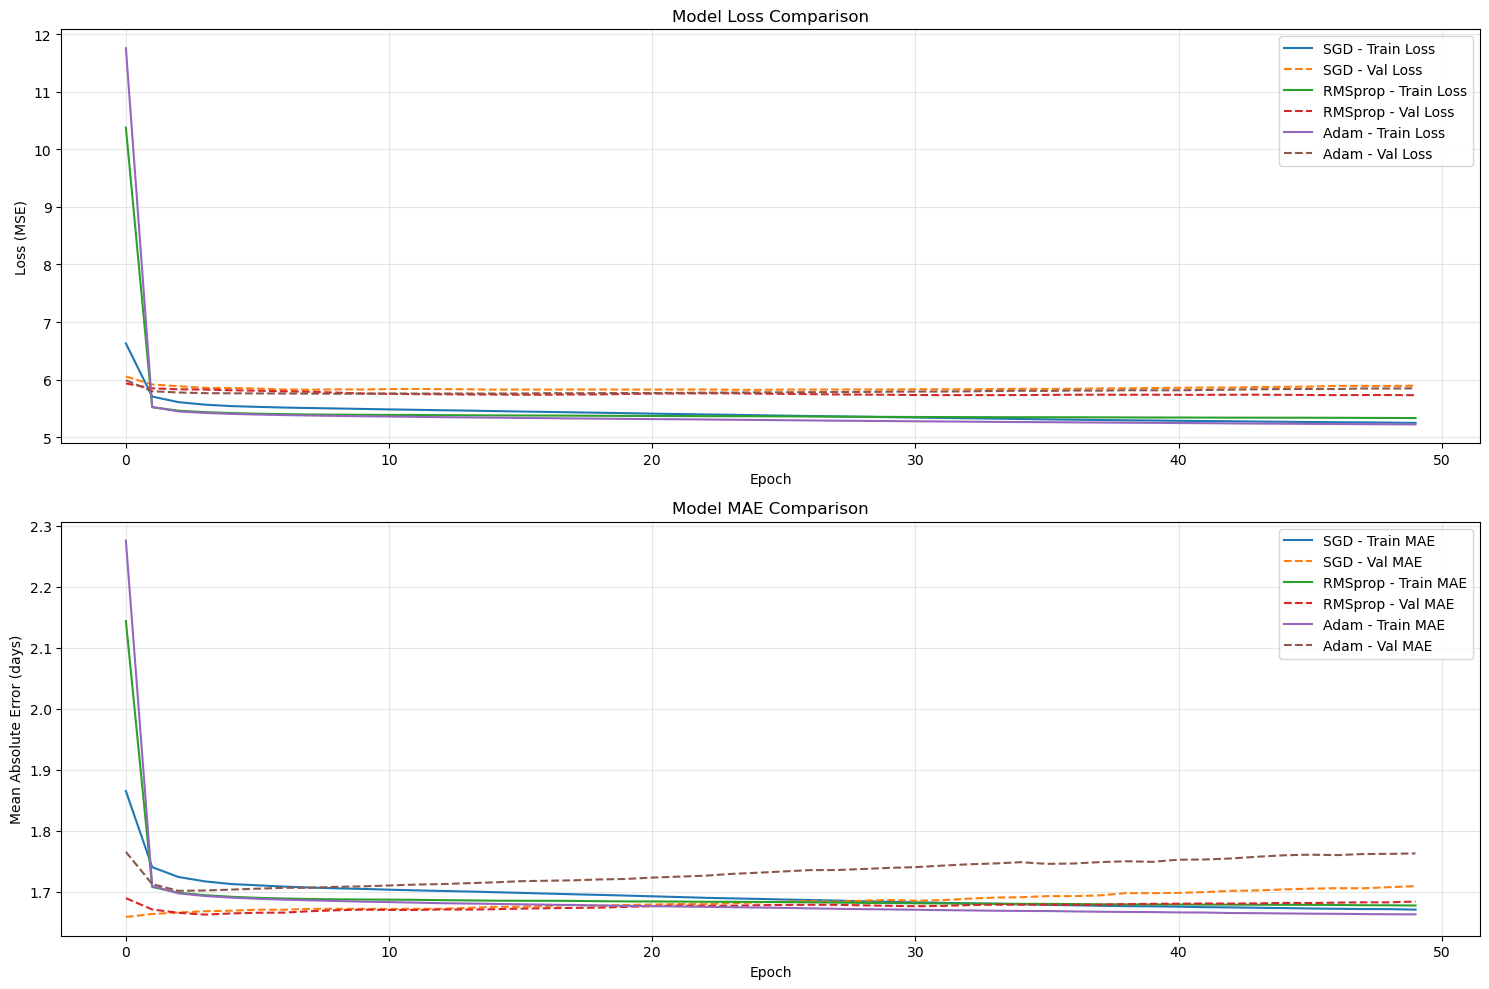

Final metrics:
SGD - Training Loss: 5.2457, Validation Loss: 5.8914
SGD - Training MAE: 1.6703, Validation MAE: 1.7089
RMSprop - Training Loss: 5.3298, Validation Loss: 5.7268
RMSprop - Training MAE: 1.6770, Validation MAE: 1.6835
Adam - Training Loss: 5.2193, Validation Loss: 5.8464
Adam - Training MAE: 1.6626, Validation MAE: 1.7625


In [22]:
# Train the model with SGD
history_sgd = model_sgd.fit(
    X_train_processed, y_train,
    validation_split=0.2,
    epochs=epochs,
    batch_size=batch_size,
    verbose=1
)
# Train the model with RMSprop
history_rmsprop = model_rmsprop.fit(
    X_train_processed, y_train,
    validation_split=0.2,
    epochs=epochs,
    batch_size=batch_size,
    verbose=1
)

# Train the model with Adam
history_adam = model_adam.fit(
    X_train_processed, y_train,
    validation_split=0.2,
    epochs=epochs,
    batch_size=batch_size,
    verbose=1
)

# Plot training & validation loss for all three models - include label for each
plt.figure(figsize=(15, 10))

# Loss comparison
plt.subplot(2, 1, 1)
# Training loss SGD
plt.plot(history_sgd.history['loss'], label='SGD - Train Loss')
# Validation loss SGD
plt.plot(history_sgd.history['val_loss'], linestyle='--', label='SGD - Val Loss')
# Training loss RMSProp
plt.plot(history_rmsprop.history['loss'], label='RMSprop - Train Loss')
# Validation loss RMSProp
plt.plot(history_rmsprop.history['val_loss'], linestyle='--', label='RMSprop - Val Loss')
# Training loss Adam
plt.plot(history_adam.history['loss'], label='Adam - Train Loss')
# Validation loss Adam
plt.plot(history_adam.history['val_loss'], linestyle='--', label='Adam - Val Loss')
plt.title('Model Loss Comparison')
plt.ylabel('Loss (MSE)')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True, alpha=0.3)

# MAE comparison
plt.subplot(2, 1, 2)
# Training MAE SGD
plt.plot(history_sgd.history['mae'], label='SGD - Train MAE')
# Validation MAE SGD
plt.plot(history_sgd.history['val_mae'], linestyle='--', label='SGD - Val MAE')
# Training MAE RMSProp
plt.plot(history_rmsprop.history['mae'], label='RMSprop - Train MAE')
# Validation MAE RMSProp
plt.plot(history_rmsprop.history['val_mae'], linestyle='--', label='RMSprop - Val MAE')
# Training MAE Adam
plt.plot(history_adam.history['mae'], label='Adam - Train MAE')
# Validation MAE Adam
plt.plot(history_adam.history['val_mae'], linestyle='--', label='Adam - Val MAE')

plt.title('Model MAE Comparison')
plt.ylabel('Mean Absolute Error (days)')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print final metrics for each optimizer
print("Final metrics:")
print(f"SGD - Training Loss: {history_sgd.history['loss'][-1]:.4f}, Validation Loss: {history_sgd.history['val_loss'][-1]:.4f}")
print(f"SGD - Training MAE: {history_sgd.history['mae'][-1]:.4f}, Validation MAE: {history_sgd.history['val_mae'][-1]:.4f}")
print(f"RMSprop - Training Loss: {history_rmsprop.history['loss'][-1]:.4f}, Validation Loss: {history_rmsprop.history['val_loss'][-1]:.4f}")
print(f"RMSprop - Training MAE: {history_rmsprop.history['mae'][-1]:.4f}, Validation MAE: {history_rmsprop.history['val_mae'][-1]:.4f}")
print(f"Adam - Training Loss: {history_adam.history['loss'][-1]:.4f}, Validation Loss: {history_adam.history['val_loss'][-1]:.4f}")
print(f"Adam - Training MAE: {history_adam.history['mae'][-1]:.4f}, Validation MAE: {history_adam.history['val_mae'][-1]:.4f}")

## Step 6: Evaluate Model Performance on Test Data
Select the best-performing model based on validation results, and evaluate it on the test set.

The best performing model used the RMSprop optimizer.

Test Loss (MSE): 5.6700
Test MAE: 1.6792 days
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 145us/step


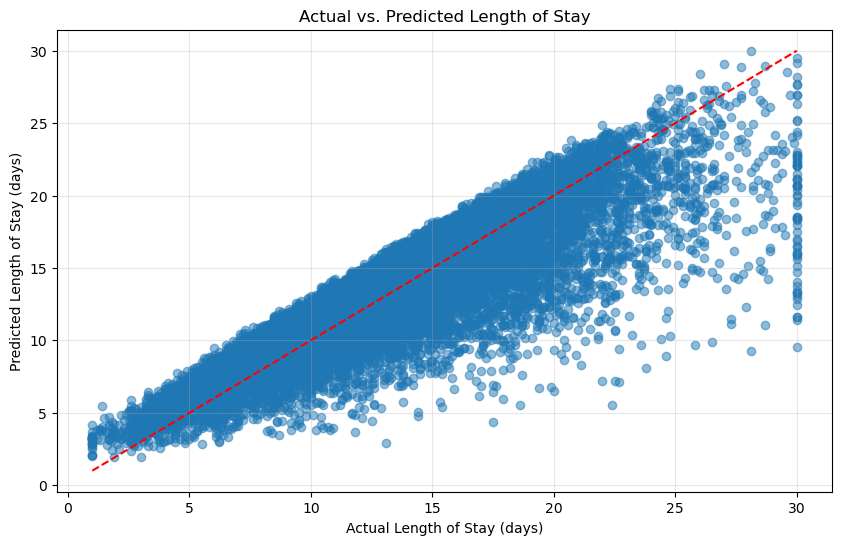

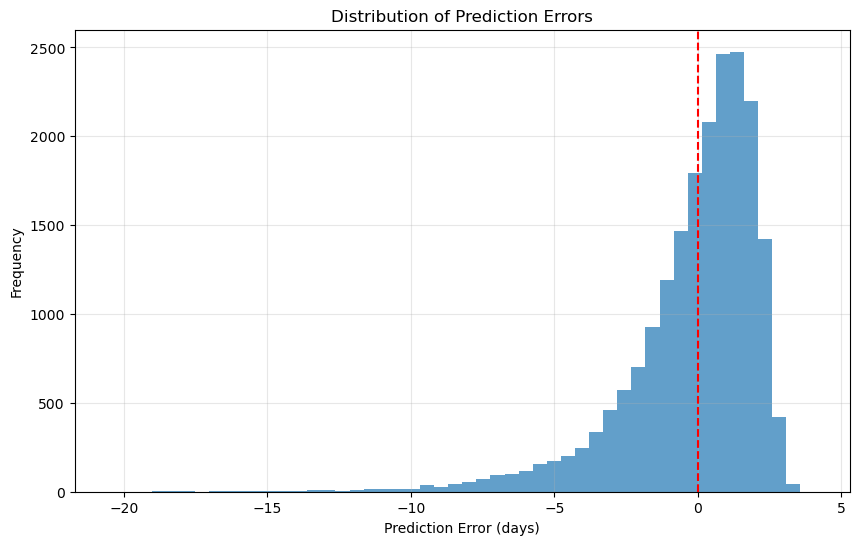

Mean Absolute Error (MAE): 1.68 days
Mean Squared Error (MSE): 5.67
Root Mean Squared Error (RMSE): 2.38 days
Mean Error: -0.17 days
Median Error: 0.41 days
Maximum Error: 20.48 days


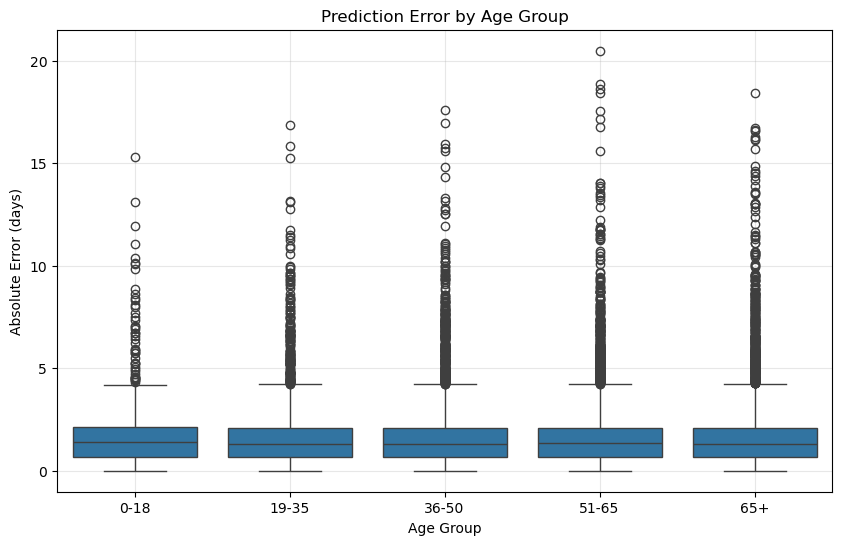

In [26]:
# Determine the best model based on validation loss
val_losses = [
    history_sgd.history['val_loss'][-1],
    history_rmsprop.history['val_loss'][-1], 
    history_adam.history['val_loss'][-1]
]

best_model_idx = np.argmin(val_losses)
best_models = [model_sgd, model_rmsprop, model_adam]
best_model = best_models[best_model_idx]
best_optimizer = ['SGD', 'RMSprop', 'Adam'][best_model_idx]

print(f"The best performing model used the {best_optimizer} optimizer.")

# Evaluate the best model on the test set
test_loss, test_mae = best_model.evaluate(X_test_processed, y_test, verbose=0)
print(f"\nTest Loss (MSE): {test_loss:.4f}")
print(f"Test MAE: {test_mae:.4f} days")

# Make predictions with the best model - hint - make sure to flatten
predictions = best_model.predict(X_test_processed).flatten()
errors = predictions - y_test

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, predictions, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Length of Stay (days)')
plt.ylabel('Predicted Length of Stay (days)')
plt.title('Actual vs. Predicted Length of Stay')
plt.grid(True, alpha=0.3)
plt.show()

# Plot error distribution
plt.figure(figsize=(10, 6))
plt.hist(errors, bins=50, alpha=0.7)
plt.axvline(x=0, color='r', linestyle='--')
plt.xlabel('Prediction Error (days)')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Errors')
plt.grid(True, alpha=0.3)
plt.show()

# Calculate additional error metrics
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
mean_error = np.mean(errors)
median_error = np.median(errors)
max_error = np.max(np.abs(errors))

print(f"Mean Absolute Error (MAE): {mae:.2f} days")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f} days")
print(f"Mean Error: {mean_error:.2f} days")
print(f"Median Error: {median_error:.2f} days")
print(f"Maximum Error: {max_error:.2f} days")

# Analyze errors by patient characteristics
# Join predictions with original test data for analysis
test_indices = y_test.index
test_data = data.iloc[test_indices].copy()
test_data['predicted_los'] = predictions
test_data['error'] = errors
test_data['abs_error'] = np.abs(errors)

# Example: Error by age group
test_data['age_group'] = pd.cut(test_data['age'], bins=[0, 18, 35, 50, 65, 100], 
                               labels=['0-18', '19-35', '36-50', '51-65', '65+'])

plt.figure(figsize=(10, 6))
sns.boxplot(x='age_group', y='abs_error', data=test_data)
plt.title('Prediction Error by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Absolute Error (days)')
plt.grid(True, alpha=0.3)
plt.show()

## Step 7: Final Evaluation and Analysis
Evaluate the performance of your best model and generate key insights for stakeholders.

In [27]:
# Calculate performance within different error margins
within_1day = np.mean(np.abs(errors) <= 1) * 100
within_2days = np.mean(np.abs(errors) <= 2) * 100
within_3days = np.mean(np.abs(errors) <= 3) * 100

print("\nPrediction Accuracy:")
print(f"Predictions within 1 day of actual: {within_1day:.1f}%")
print(f"Predictions within 2 days of actual: {within_2days:.1f}%")
print(f"Predictions within 3 days of actual: {within_3days:.1f}%")

# Analyze which types of cases are most difficult to predict
# Group test cases by quartiles of error magnitude
test_data['error_quartile'] = pd.qcut(test_data['abs_error'], 4, labels=['Q1', 'Q2', 'Q3', 'Q4'])

# Examine characteristics of the highest error cases
high_error_cases = test_data[test_data['error_quartile'] == 'Q4']

print("\nCharacteristics of Difficult-to-Predict Cases:")
print(f"Average age: {high_error_cases['age'].mean():.1f} years")
print(f"Average length of stay: {high_error_cases['length_of_stay'].mean():.1f} days")
print(f"Average number of procedures: {high_error_cases['num_procedures'].mean():.1f}")

# Generate insights for stakeholders
print("\nKey Insights for Hospital Administrators:")
print("1. The model can predict patient length of stay with an average error of " +
      f"{np.mean(np.abs(errors)):.2f} days.")
print(f"2. {within_2days:.1f}% of predictions are within 2 days of the actual length of stay.")
print("3. The model has similar error for all age groups indicating no systemic age bias.")


Prediction Accuracy:
Predictions within 1 day of actual: 37.9%
Predictions within 2 days of actual: 72.4%
Predictions within 3 days of actual: 89.4%

Characteristics of Difficult-to-Predict Cases:
Average age: 54.2 years
Average length of stay: 15.1 days
Average number of procedures: 2.0

Key Insights for Hospital Administrators:
1. The model can predict patient length of stay with an average error of 1.68 days.
2. 72.4% of predictions are within 2 days of the actual length of stay.
3. The model has similar error for all age groups indicating no systemic age bias.
